<a href="https://colab.research.google.com/github/LuisEduardoRB/EDP-II/blob/main/Examen_Sistemas_Financieros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BLOQUE 0 – Configuración general y variable `HOY`

En este trabajo se usará una fecha de referencia llamada `HOY`, que será el centro temporal de todo el análisis.  
A partir de `HOY` se definen:

- Los últimos **3 años** de datos históricos.  
- Los últimos **2 años** de datos históricos.  
- Un periodo de **2 años hacia adelante** para hacer proyecciones.

Para este documento se asume inicialmente:

- `HOY = 28 de noviembre de 2022`.

Si se desea cambiar la fecha de análisis, únicamente se debe modificar el valor de `HOY` y todas las demás fechas se ajustan de forma automática.

Las acciones analizadas serán:

- **NVDA** (NVIDIA Corporation)  
- **KO** (The Coca-Cola Company)  
- **JPM** (JPMorgan Chase & Co.)  

Estas se eligieron para representar una acción muy volátil, una estable y una de volatilidad intermedia.

In [69]:
# BLOQUE 0 – Configuración general y variable HOY

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


# Variable central: fecha de 'HOY'
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - HOY define el "presente" para TODO el análisis.
#   Desde aquí se calculan los rangos de 2 y 3 años hacia atrás y la proyección hacia adelante.
#
# Puedes cambiarla a cualquier fecha:
#   HOY = pd.Timestamp(2023, 12, 31)
#   HOY = pd.Timestamp("2024-06-01")
#
# Si la cambias, automáticamente se actualizan:
#   - start_3y, start_2y, end_hist, end_2y_forward
HOY = pd.Timestamp(2022, 11, 28)  # <-- cámbiala aquí si quieres otro "hoy"

# Fechas derivadas
# ------------------------------------------------------------------
# Todas dependen de HOY:
#
# - start_3y: 3 años antes de HOY (para análisis de 3 años).
# - start_2y: 2 años antes de HOY (para análisis de 2 años).
# - end_hist: fecha final del histórico (igual a HOY).
#
# Si cambias HOY o cambias "years=3" / "years=2", modificas el horizonte histórico.
start_3y = HOY - pd.DateOffset(years=3)   # 3 años antes de HOY
start_2y = HOY - pd.DateOffset(years=2)   # 2 años antes de HOY
end_hist = HOY                            # hasta HOY

# Fechas para proyección 2 años hacia adelante
# ------------------------------------------------------------------
# end_2y_forward: fecha futura hasta donde vas a proyectar (por ejemplo, en Monte Carlo o señales).
# Puedes cambiar el horizonte:
#   - pd.DateOffset(years=1)
#   - pd.DateOffset(months=6)
end_2y_forward = HOY + pd.DateOffset(years=2)

# Tickers elegidos
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - tickers: lista de activos que usas en TODO el análisis.
#   - [ "NVDA", "KO", "JPM" ] en este caso.
#
# Puedes añadir o cambiar activos:
#   tickers = ["AAPL", "MSFT"]
#   tickers = ["NVDA", "KO", "JPM", "TSLA"]
#
# OJO:
# - Si cambias la cantidad de tickers, también tienes que ajustar:
#   - el vector de pesos 'weights' más adelante
#   - algunos gráficos (número de subplots, etc.).
tickers = ["NVDA", "KO", "JPM"]

# Función auxiliar para descargar precios ajustados
# ------------------------------------------------------------------
# get_adj_close(symbols, start, end):
#
# PARÁMETROS:
# - symbols:
#     * Puede ser:
#         - Un string: "AAPL", "^GSPC", "^IRX", etc.
#         - Una lista de strings: ["NVDA", "KO", "JPM"]
# - start:
#     * Fecha inicial del período que quieres descargar (start_2y, start_3y, start_signals, etc.)
# - end:
#     * Fecha final (end_hist, end_2y_forward, etc.)
#
# Internamente:
# - yf.download(...) baja datos OHLCV.
# - auto_adjust=False → los precios ajustados (por dividendos/splits) se toman de "Adj Close".
def get_adj_close(symbols, start, end):
    data = yf.download(symbols, start=start, end=end, auto_adjust=False)
    adj_close_data = data["Adj Close"]

    if isinstance(adj_close_data, pd.Series):
        # Caso 1: un solo símbolo -> yfinance regresa una Serie.
        # La convertimos a DataFrame con el nombre del símbolo como columna.
        return adj_close_data.to_frame(name=symbols)
    elif isinstance(adj_close_data, pd.DataFrame):
        # Caso 2: múltiples símbolos -> ya viene como DataFrame.
        # Lo regresamos tal cual.
        return adj_close_data
    else:
        # Caso raro: tipo inesperado.
        raise TypeError(f"Unexpected type for 'Adj Close' data: {type(adj_close_data)}")



# BLOQUE 1 – Pregunta 2: Selección de acciones

**Pregunta:**  
Elija tres empresas que coticen en bolsa de USA, tratando de escoger una con cotización muy volátil, otra con cotización muy estable y otra con un nivel intermedio. Justifique su respuesta.

**Respuesta:**

- **NVDA (NVIDIA) – Acción muy volátil**  
  NVIDIA es una empresa de semiconductores y tecnología cuya valuación está fuertemente ligada a expectativas de crecimiento en inteligencia artificial, data centers y gaming.  
  Este tipo de empresa tiende a presentar:
  - Movimientos diarios amplios en el precio.  
  - Alta sensibilidad a noticias sobre resultados trimestrales, regulación, cadenas de suministro y cambios en las tasas de interés.  
  Por ello se considera una acción **de alta volatilidad**.

- **KO (Coca-Cola) – Acción estable**  
  Coca-Cola es una empresa de consumo defensivo con un negocio maduro y estable, orientado a productos de bebidas con demanda relativamente poco sensible al ciclo económico.  
  Características:
  - Ingresos y flujos de efectivo estables.  
  - Pago constante de dividendos.  
  - Menor sensibilidad a shocks macroeconómicos que empresas de crecimiento.  
  Esto la hace una acción con comportamiento **más estable** y típicamente con **beta menor a 1**.

- **JPM (JPMorgan) – Acción de volatilidad intermedia**  
  JPMorgan es uno de los bancos más grandes de Estados Unidos, cuyo desempeño está ligado al ciclo económico y a las tasas de interés.  
  Propiedades:
  - Más sensible al entorno macroeconómico que una empresa defensiva como KO.  
  - Menos extrema (en subidas y bajadas) que una empresa de alto crecimiento como NVDA.  
  En conjunto, JPM se considera un activo con **nivel de volatilidad intermedio**.


# BLOQUE 2 – Pregunta 3: Información de los últimos 3 años

**Pregunta:**  
Consulte la información de dichas acciones para los últimos tres años anteriores al día de HOY.

**Respuesta:**

Tomando como referencia la fecha `HOY`, se consideran los **tres años previos**, es decir, el intervalo:

- Desde: `HOY - 3 años`.  
- Hasta: `HOY`.

Para las acciones **NVDA**, **KO** y **JPM** se obtiene:

1. La serie de **precios de cierre ajustados diarios** para cada una de las tres acciones en ese periodo.  
2. A partir de estos precios se calculan los **rendimientos diarios simples** mediante:  
   $r_t = \dfrac{P_t - P_{t-1}}{P_{t-1}}$
3. Se genera una base de datos con:
   - Fechas en las filas.  
   - Las columnas correspondientes a NVDA, KO y JPM, tanto para precios como para rendimientos.

Esta información servirá como insumo para los cálculos de volatilidad, VaR, betas y construcción del portafolio.


In [82]:
# BLOQUE 2 – Pregunta 3: Datos de los últimos 3 años

# Descarga de precios ajustados de los últimos 3 años
# - tickers: lista de símbolos de las acciones/activos a descargar (por ejemplo ["AAPL", "MSFT"])
# - start_3y: fecha inicial de la serie histórica de 3 años (por ejemplo "2022-01-01")
# - end_hist: fecha final de la serie histórica (por ejemplo "2025-01-01")
#   Suele ser la fecha más reciente disponible o la fecha de corte del análisis.
prices_3y = get_adj_close(tickers, start_3y, end_hist)

# Ordenar por fecha por si acaso
# Nos aseguramos de que el índice temporal (las fechas) esté ordenado de menor a mayor,
# porque algunos cálculos de series de tiempo (como pct_change) suponen un orden cronológico.
prices_3y = prices_3y.sort_index()

# Cálculo de rendimientos diarios simples
# pct_change():
#   - Por defecto calcula el cambio porcentual respecto al periodo anterior (periods=1).
#   - Es decir, return_t = (price_t / price_{t-1}) - 1.
# dropna():
#   - Elimina las primeras filas que quedan como NaN porque no hay precio anterior
#     para calcular el primer rendimiento, y cualquier otra observación vacía que aparezca.
returns_3y = prices_3y.pct_change().dropna()

print("Primeras filas de precios (3 años):")
print(prices_3y.head())

print("\nPrimeras filas de rendimientos diarios (3 años):")
print(returns_3y.head())


[*********************100%***********************]  3 of 3 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: JSONDecodeError('unexpected character: line 1 column 1 (char 0)')


Primeras filas de precios (3 años):
Ticker             JPM         KO  NVDA
Date                                   
2019-11-29  111.666214  44.422417   NaN
2019-12-02  111.420448  44.713577   NaN
2019-12-03  109.988167  44.755169   NaN
2019-12-04  112.157761  45.162792   NaN
2019-12-05  112.767960  45.079601   NaN

Primeras filas de rendimientos diarios (3 años):
Empty DataFrame
Columns: [JPM, KO, NVDA]
Index: []


/tmp/ipython-input-901238893.py:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_3y = prices_3y.pct_change().dropna()



# BLOQUE 3 – Pregunta 3.1: Volatilidad histórica diaria (últimos 2 años)

**Pregunta:**  
Calcule su volatilidad histórica diaria de los últimos dos años. Grafique para hacer una comparación de su comportamiento.

**Respuesta:**

Se considera el periodo de los **últimos 2 años** previos a `HOY`, es decir:

- Desde: `HOY - 2 años`.  
- Hasta: `HOY`.

Para cada una de las acciones **NVDA**, **KO** y **JPM** se realiza lo siguiente:

1. Se obtienen los **precios de cierre ajustados diarios** en ese intervalo.  
2. Se calculan los **rendimientos diarios**.  
3. La **volatilidad histórica diaria** de cada acción se estima como la **desviación estándar** de sus rendimientos diarios en esos 2 años:  
   $\sigma_i = sd(r_{i,t})$
4. Se comparan numéricamente las volatilidades de NVDA, KO y JPM:
   - NVDA debe presentar la **volatilidad más alta**.  
   - KO la **más baja**.  
   - JPM un nivel **intermedio**.

Además, se realiza una gráfica de los **precios históricos** de cada acción en los últimos 2 años, para visualizar:

- La magnitud y frecuencia de las fluctuaciones.  
- Diferencias cualitativas entre la acción volátil (NVDA), la estable (KO) y la intermedia (JPM).

Opcionalmente se puede graficar también una **volatilidad rodante** (por ejemplo, con ventana de 20 días) para observar cómo cambia el riesgo en el tiempo.

[*********************100%***********************]  3 of 3 completed


Volatilidad histórica diaria (últimos 2 años):
Ticker
JPM     0.016430
KO      0.011092
NVDA    0.033869
dtype: float64


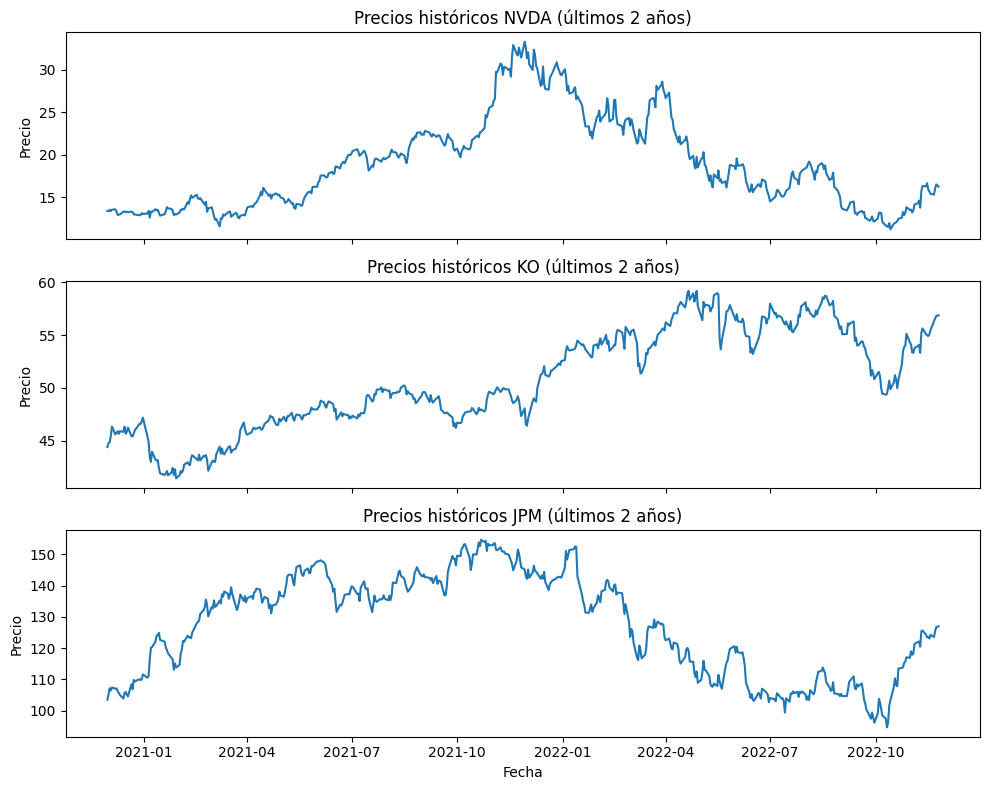

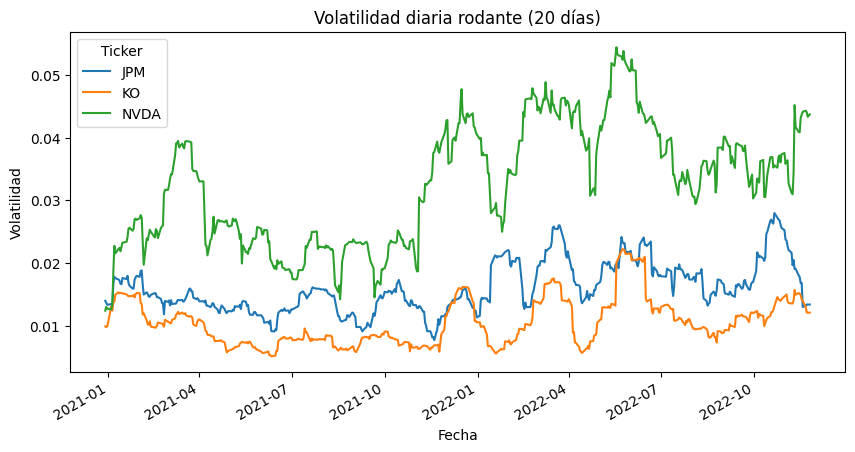

In [83]:
# BLOQUE 3 – Pregunta 3.1: Volatilidad histórica diaria (últimos 2 años)

# Precios para los últimos 2 años
# ------------------------------------------------------------------
# VARIABLES CLAVE QUE PUEDES CAMBIAR:
# - tickers: lista de activos, por ejemplo ["AAPL", "MSFT", "TSLA"]
# - start_2y: fecha de inicio del período (ej. "2023-01-01")
# - end_hist: fecha de fin (ej. "2025-01-01"); puede ser una fecha fija o "hoy"
# Si cambias start_2y y end_hist, estás cambiando el rango de tiempo analizado.
prices_2y = get_adj_close(tickers, start_2y, end_hist)

# Ordenar por fecha por si acaso (importante si cambias fuentes de datos)
prices_2y = prices_2y.sort_index()

# Rendimientos diarios (2 años)
# pct_change() por defecto usa periods=1 (rendimiento diario).
# Si quisieras rendimientos semanales/mensuales:
#   returns_2y = prices_2y.pct_change(periods=5)      # aprox. semanal
#   returns_2y = prices_2y.pct_change(periods=21)     # aprox. mensual
returns_2y = prices_2y.pct_change().dropna()

# Volatilidad diaria histórica (2 años)
# std() calcula la desviación estándar de TODA la muestra de rendimientos.
# Si cambias el rango de fechas o el tipo de rendimiento, cambia esta volatilidad.
vol_daily_2y = returns_2y.std()

print("Volatilidad histórica diaria (últimos 2 años):")
print(vol_daily_2y)

# Gráfica de precios para comparación visual
# ------------------------------------------------------------------
# VARIABLES GRÁFICAS QUE PUEDES CAMBIAR:
# - 3: número de filas de subgráficas (si tienes más/menos tickers, ajusta esto)
# - 1: número de columnas (normalmente 1)
# - figsize=(10, 8): tamaño de la figura (ancho, alto)
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i, ticker in enumerate(tickers):
    # Si quieres cambiar tipo de línea, grosor, etc., puedes añadir argumentos:
    # axes[i].plot(prices_2y.index, prices_2y[ticker], linewidth=1.2)
    axes[i].plot(prices_2y.index, prices_2y[ticker])
    axes[i].set_title(f"Precios históricos {ticker} (últimos 2 años)")
    axes[i].set_ylabel("Precio")

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()

# Volatilidad rodante de 20 días (opcional)
# ------------------------------------------------------------------
# rolling(window=20) utiliza una ventana móvil de 20 días.
# VARIABLE CLAVE:
# - window=20: número de días para el cálculo de volatilidad rodante.
#   Ejemplos:
#   - window=10   -> ventana más corta, volatilidad más "ruidosa"
#   - window=60   -> ventana más larga, volatilidad más "suavizada"
rolling_vol_20 = returns_2y.rolling(window=20).std()

# También puedes cambiar el tamaño de la figura de esta gráfica:
rolling_vol_20.plot(figsize=(10, 5))
plt.title("Volatilidad diaria rodante (20 días)")
plt.ylabel("Volatilidad")
plt.xlabel("Fecha")
plt.show()



# BLOQUE 4 – Pregunta 4: Construcción del portafolio

**Pregunta:**  
Construya un portafolio asignando tres pesos diferentes a estas tres acciones, argumente la diversificación en base a la volatilidad de los instrumentos individuales.

**Respuesta:**

Con base en las características de volatilidad de las acciones:

- **NVDA**: acción de alta volatilidad.  
- **KO**: acción relativamente estable.  
- **JPM**: acción con riesgo intermedio.

Se propone el siguiente esquema de pesos:

- $w_{\text{NVDA}} = 0.20$  
- $w_{\text{KO}}   = 0.50$  
- $w_{\text{JPM}}  = 0.30$

Estos pesos reflejan:

- Una mayor exposición a **KO**, que aporta estabilidad al portafolio.  
- Una posición intermedia en **JPM**, que equilibra riesgo y rendimiento.  
- Una menor exposición a **NVDA**, que es la más volátil, para evitar que el portafolio sea excesivamente riesgoso.

Con estos pesos y los rendimientos diarios de los últimos años, se calcula el **rendimiento diario del portafolio** como:  
$r_{p,t} = w_{\text{NVDA}} r_{\text{NVDA},t} + w_{\text{KO}} r_{\text{KO},t} + w_{\text{JPM}} r_{\text{JPM},t}$

Así se obtiene una serie de rendimientos del portafolio que combina los tres perfiles de riesgo, buscando diversificación.

In [72]:
# BLOQUE 4 – Pregunta 4: Construcción del portafolio

# Pesos del portafolio [NVDA, KO, JPM]
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - weights: vector de pesos del portafolio.
#   Debe tener la MISMA longitud que la lista 'tickers' y en el mismo orden.
#   Ejemplo:
#   - tickers = ["NVDA", "KO", "JPM"]
#   - weights = np.array([0.2, 0.5, 0.3])
# Puedes cambiar estos pesos para simular diferentes composiciones:
#   - np.array([0.33, 0.33, 0.34])   -> portafolio casi equiponderado
#   - np.array([0.6, 0.2, 0.2])      -> más peso a NVDA
# Idealmente que la suma sea 1, aunque NumPy no se va a quejar si no.
weights = np.array([0.2, 0.5, 0.3])

# Asegurar orden de columnas
# ------------------------------------------------------------------
# Aquí nos aseguramos de que 'returns_2y' y 'returns_3y' tengan las columnas
# en el mismo orden que 'tickers', para que el producto @ con 'weights'
# tenga sentido económico (y no mezcles pesos de una acción con otra).
# VARIABLES QUE IMPACTAN:
# - tickers: cambia la composición del portafolio (y el orden de las columnas).
returns_2y = returns_2y[tickers]
returns_3y = returns_3y[tickers]

# Rendimientos diarios del portafolio usando 3 años
# ------------------------------------------------------------------
# 'returns_3y' es un DataFrame (fechas x activos).
# 'weights' es un vector (activos x 1).
# La operación '@' (producto matricial) calcula el rendimiento diario del portafolio:
#   return_port_t = sum_i ( weight_i * return_{i,t} )
# Si cambias:
#   - el período de 'returns_3y' (rango de fechas),
#   - los activos en 'tickers',
#   - o 'weights',
# entonces cambias esta serie de rendimientos del portafolio.
returns_port_3y = returns_3y @ weights

# Rendimientos diarios del portafolio solo en los últimos 2 años
# ------------------------------------------------------------------
# Misma lógica de arriba, pero restringido al horizonte de 2 años.
# De nuevo, se ve afectado por:
#   - el rango temporal usado para construir 'returns_2y',
#   - los pesos 'weights',
#   - los activos en 'tickers'.
returns_port_2y = returns_2y @ weights

print("Primeras filas de rendimientos diarios del portafolio (2 años):")
print(returns_port_2y.head())


Primeras filas de rendimientos diarios del portafolio (2 años):
Date
2020-12-01    0.008826
2020-12-02    0.008743
2020-12-03    0.002328
2020-12-04    0.015281
2020-12-07   -0.008398
dtype: float64



# BLOQUE 5 – Pregunta 5: Distribución de un millón de pesos

**Pregunta:**  
Distribuya un millón de pesos en este portafolio (sin considerar comisiones ni impuestos).

**Respuesta:**

Se considera una inversión inicial total de:

- $V_0 = 1{,}000{,}000$ pesos.

Con los pesos propuestos:

- $w_{\text{NVDA}} = 0.20$  
- $w_{\text{KO}}   = 0.50$  
- $w_{\text{JPM}}  = 0.30$

El capital asignado a cada activo es:

- NVDA:  
  $V_{\text{NVDA}} = 1{,}000{,}000 \times 0.20 = 200{,}000$
- KO:  
  $V_{\text{KO}} = 1{,}000{,}000 \times 0.50 = 500{,}000$
- JPM:  
  $V_{\text{JPM}} = 1{,}000{,}000 \times 0.30 = 300{,}000$

Además, usando los rendimientos diarios del portafolio en los últimos 2 años, se puede obtener la **evolución del valor del portafolio**:  
$V_t = V_0 \cdot \prod_{s \le t} (1 + r_{p,s})$

Esto permite observar cuánto habría valido el portafolio en cada fecha del periodo analizado.

Distribución inicial de 1,000,000 en el portafolio:
NVDA    200000.0
KO      500000.0
JPM     300000.0
dtype: float64

Valor final del portafolio al final del periodo de 2 años:
1319086.6105007739


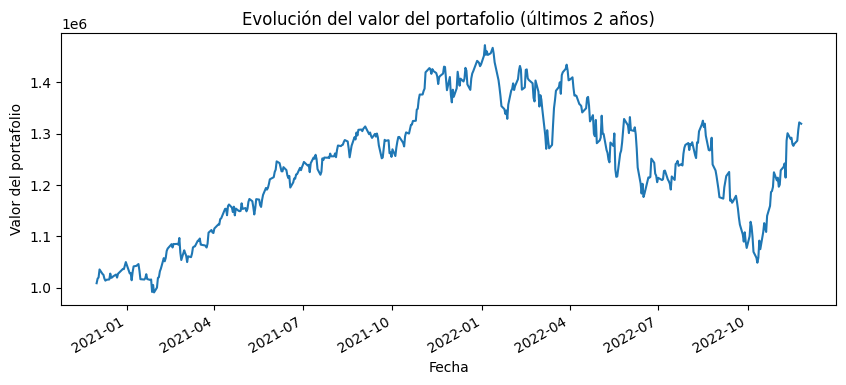

In [84]:
# BLOQUE 5 – Pregunta 5: Distribuir un millón de pesos en el portafolio

# Monto inicial invertido
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - inv_ini: capital inicial a invertir.
#   Puedes cambiarlo según el escenario:
#   - 1_000_000  -> un millón
#   - 500_000    -> medio millón
#   - 2_000_000  -> dos millones, etc.
inv_ini = 1_000_000

# Monto invertido en cada activo
# ------------------------------------------------------------------
# 'weights' viene del bloque anterior:
#   - Es el vector de pesos del portafolio (porcentaje en cada activo).
# 'asignacion' calcula cuánto dinero en pesos va a cada activo:
#   asignacion_i = inv_ini * weight_i
# Si cambias:
#   - inv_ini      -> cambia el tamaño total de la inversión.
#   - weights      -> cambia cuánto se asigna a cada activo.
asignacion = inv_ini * weights

# Creamos una Serie de pandas con nombres de activos en el índice
# para que la salida sea legible.
# VARIABLES ASOCIADAS:
#   - tickers: define el nombre de cada activo en la distribución.
dist_asignacion = pd.Series(asignacion, index=tickers)

print("Distribución inicial de 1,000,000 en el portafolio:")
print(dist_asignacion)

# Evolución del valor del portafolio en los últimos 2 años
# ------------------------------------------------------------------
# 'returns_port_2y' es la serie de rendimientos diarios del portafolio
# (construida en el bloque anterior).
#
# Fórmula:
#   (1 + returns_port_2y).cumprod()
#   -> factor de crecimiento acumulado del portafolio en el tiempo.
#
# Luego se multiplica por 'inv_ini' para obtener el valor en pesos:
#   valor_portafolio_t = inv_ini * Π(1 + r_port_s) desde s=1 hasta t
#
# COSAS QUE IMPACTAN ESTE CÁLCULO:
#   - inv_ini: escala todo el valor del portafolio.
#   - returns_port_2y: depende de pesos, activos y rango de tiempo (2 años).
valor_portafolio_2y = inv_ini * (1 + returns_port_2y).cumprod()

print("\nValor final del portafolio al final del periodo de 2 años:")
print(valor_portafolio_2y.iloc[-1])

# Gráfica de la evolución del valor del portafolio
# ------------------------------------------------------------------
# VARIABLES VISUALES QUE PUEDES CAMBIAR:
#   - figsize=(10, 4): tamaño de la figura (ancho, alto).
#   - título del gráfico para reflejar otro rango o escenario.
valor_portafolio_2y.plot(figsize=(10, 4))
plt.title("Evolución del valor del portafolio (últimos 2 años)")
plt.ylabel("Valor del portafolio")
plt.xlabel("Fecha")
plt.show()



# BLOQUE 6 – Pregunta 6: VaR diario de los activos individuales

**Pregunta:**  
Calcule el Valor en Riesgo (VaR) diario de los últimos dos años de cada uno de los activos individuales.

**Respuesta:**

Se considera el periodo de los **últimos 2 años** previos a `HOY`.  
Para cada acción (NVDA, KO, JPM):

1. Se toman los **rendimientos diarios** de ese periodo.  
2. Se calcula el **VaR histórico al 95%**.  
   El VaR histórico al 95% se puede interpretar como la pérdida mínima que se supera solo en el 5% de los peores días.  

   Matemáticamente, para cada activo $i$:
   - Se obtiene el cuantil del 5% de los rendimientos

   - El VaR se reporta como un número positivo de pérdida:  
     $\text{VaR}_i = -q_i$

La interpretación es:

- Para cada activo, el VaR diario al 95% indica cuál es la pérdida diaria que, bajo condiciones históricas similares, solo se supera en el 5% de los peores días.  
- En general, se espera:
  - VaR de **NVDA** > VaR de **JPM** > VaR de **KO**, consistente con sus niveles de volatilidad.

In [87]:
# BLOQUE 6 – Pregunta 6: VaR diario de los activos individuales (2 años)

def historical_var(returns, alpha=0.95):
    """
    VaR histórico al nivel alpha.
    Retorna un número positivo que representa pérdida.

    PARÁMETROS CLAVE:
    - returns: serie de rendimientos (puede ser de un activo o del portafolio).
         * Si cambias el horizonte (2 años, 3 años, 6 meses), cambian estos datos
           y por lo tanto el VaR.
    - alpha: nivel de confianza.
         * alpha=0.95  -> VaR al 95% (percentil 5% de la cola izquierda).
         * alpha=0.99  -> VaR al 99% (más conservador, pérdidas más extremas).
    """
    # Cuantil en la cola izquierda: 1 - alpha
    #   Si alpha=0.95 -> 1 - alpha = 0.05 -> percentil 5%
    q = np.quantile(returns, 1 - alpha)

    # Multiplicamos por -1 para reportar el VaR como número positivo de pérdida.
    # Ejemplo:
    #   q = -0.03  => -q = 0.03  -> VaR diario del 3%
    return -q  # reportamos VaR como número positivo de pérdida

# VaR diario histórico para cada activo usando 2 años de datos
# ------------------------------------------------------------------
# 'returns_2y' es un DataFrame con rendimientos diarios de los últimos 2 años.
# Cada columna es un activo, cada fila un día.
#
# apply(historical_var, alpha=0.95):
#   - Aplica la función historical_var columna por columna.
#   - alpha=0.95: aquí puedes cambiar el nivel de confianza:
#       * 0.95, 0.975, 0.99, etc.
#   - Si usas returns_3y en lugar de returns_2y:
#       VaR_individual_3y = returns_3y.apply(historical_var, alpha=0.95)
#   y así cambias el horizonte temporal del VaR.
VaR_individual_2y = returns_2y.apply(historical_var, alpha=0.95)

print("VaR diario histórico (95%) de cada activo (últimos 2 años):")
print(VaR_individual_2y)


VaR diario histórico (95%) de cada activo (últimos 2 años):
Ticker
JPM     0.026525
KO      0.017332
NVDA    0.055974
dtype: float64



# BLOQUE 7 – Pregunta 6.1: Gráfica del VaR diario

**Pregunta:**  
Grafique el Valor en Riesgo diario de los últimos dos años de cada uno de los activos individuales.

**Respuesta:**

Para obtener un VaR “dinámico”, se construye un **VaR histórico rodante**:

1. Se define una ventana móvil de, por ejemplo, **20 días**.  
2. Para cada día $t$, se toman los últimos 20 rendimientos:  
   $r_{i,t-19}, \ldots, r_{i,t}$
3. Sobre esa ventana se calcula el VaR histórico al 95%:  
   $\text{VaR}_{i,t} = \text{VaR}_{95\%}\big(r_{i,t-19}, \ldots, r_{i,t}\big)$
4. Se repite esto para cada activo (NVDA, KO, JPM), obteniendo una serie temporal de VaR para cada uno.

Luego se grafica, en el tiempo, el VaR diario rodante de los tres activos para comparar:

- Cómo cambia el riesgo de cola a lo largo del tiempo.  
- En qué periodos aumenta fuertemente el VaR (mayor riesgo).  
- La relación relativa entre el VaR de NVDA, KO y JPM.

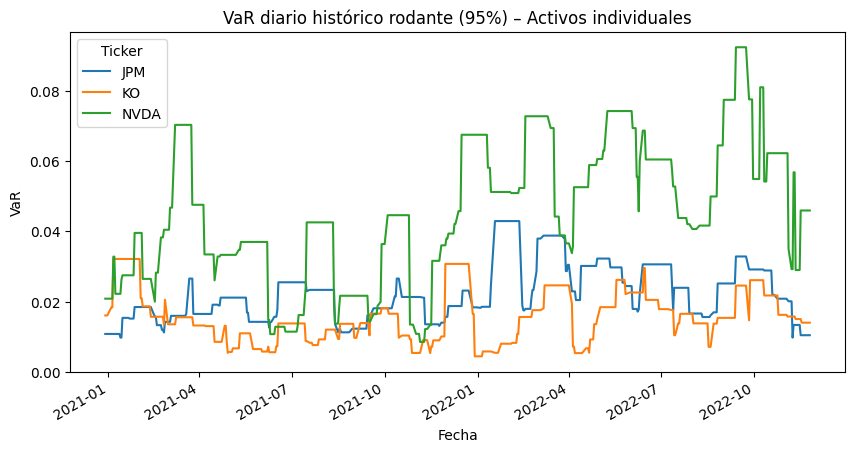

In [88]:
# BLOQUE 7 – Pregunta 6.1: VaR diario rodante de los activos

# Ventana para el VaR rodante
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - window: número de días en cada ventana móvil.
#   Ejemplos:
#   - 20  -> aprox. 1 mes de trading
#   - 60  -> ~3 meses
#   - 252 -> ~1 año de mercado
window = 20  # días

def rolling_var(series, window=20, alpha=0.95):
    """
    Calcula el VaR histórico rodante sobre una serie de rendimientos.

    PARÁMETROS:
    - series: serie de rendimientos (un activo o portafolio).
    - window: tamaño de la ventana en días.
         * Modificarlo cambia cuánta historia se usa para estimar el VaR en cada punto.
    - alpha: nivel de confianza del VaR.
         * 0.95 -> VaR al 95%
         * 0.99 -> VaR al 99%, más conservador.
    """
    return series.rolling(window=window).apply(
        lambda x: historical_var(x, alpha=alpha),
        raw=False
    )

# VaR diario histórico rodante para cada activo, usando rendimientos de 2 años
# ------------------------------------------------------------------
# VARIABLES QUE AFECTAN ESTE CÁLCULO:
# - returns_2y: horizonte temporal (2 años). Si usaras returns_3y, el VaR rodante se
#   calcularía sobre 3 años:
#       rolling_VaR_individual_3y = returns_3y.apply(rolling_var, window=window, alpha=0.95)
#
# - window: tamaño de la ventana de cálculo del VaR.
# - alpha: puedes cambiarlo en la llamada a rolling_var:
#       rolling_VaR_individual = returns_2y.apply(rolling_var, window=window, alpha=0.99)
rolling_VaR_individual = returns_2y.apply(rolling_var, window=window, alpha=0.95)

# Gráfica del VaR rodante
# ------------------------------------------------------------------
# VARIABLES VISUALES:
# - figsize=(10, 5): tamaño del gráfico.
# - título: puedes cambiar el texto si usas otro alpha o ventana.
rolling_VaR_individual.plot(figsize=(10, 5))
plt.title("VaR diario histórico rodante (95%) – Activos individuales")
plt.ylabel("VaR")
plt.xlabel("Fecha")
plt.show()



# BLOQUE 8 – Pregunta 7: VaR diario del portafolio

**Pregunta:**  
Calcule el Valor en Riesgo diario de los últimos dos años del portafolio que decidió conformar y grafique.

**Respuesta:**

1. Se utilizan los **rendimientos diarios del portafolio** en los últimos 2 años:  
   $r_{p,t} = w_{\text{NVDA}} r_{\text{NVDA},t} + w_{\text{KO}} r_{\text{KO},t} + w_{\text{JPM}} r_{\text{JPM},t}$
2. Sobre esta serie de rendimientos del portafolio se calcula:
   - El **VaR histórico diario al 95%** (un solo valor global para todo el periodo).  
   - Un **VaR rodante** (por ejemplo, con ventana de 20 días) para obtener una serie temporal de VaR del portafolio.

Interpretación:

- El VaR del portafolio refleja el riesgo de pérdida conjunta de los tres activos, tomando en cuenta sus pesos y la correlación entre ellos.  
- Se espera que el VaR del portafolio sea **inferior** a la combinación trivial de VaR individuales sin diversificación, gracias a las correlaciones imperfectas.  
- La gráfica del VaR rodante muestra cómo la exposición al riesgo extremo del portafolio varía a lo largo del tiempo.

VaR diario histórico (95%) del portafolio (2 años):
0.020397459117732646


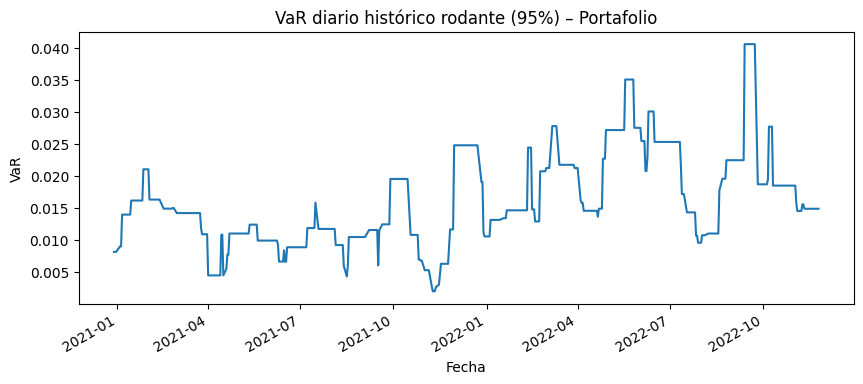

In [90]:
# BLOQUE 8 – Pregunta 7: VaR diario del portafolio (2 años)

# VaR histórico del portafolio
# ------------------------------------------------------------------
# historical_var:
#   - función definida antes que calcula el VaR histórico a un nivel de confianza alpha.
# returns_port_2y:
#   - serie de rendimientos diarios del portafolio en los últimos 2 años.
#
# PARÁMETROS CLAVE:
# - returns_port_2y:
#     * Si cambias el horizonte (por ejemplo, usas returns_port_3y),
#       el VaR cambia porque se usa otra historia:
#       VaR_port_3y = historical_var(returns_port_3y, alpha=0.95)
# - alpha=0.95:
#     * Nivel de confianza del VaR:
#       - 0.95 -> VaR al 95%
#       - 0.99 -> VaR al 99% (más conservador, pérdidas más extremas)
VaR_port_2y = historical_var(returns_port_2y, alpha=0.95)

print("VaR diario histórico (95%) del portafolio (2 años):")
print(VaR_port_2y)

# VaR rodante del portafolio
# ------------------------------------------------------------------
# Aquí calculas cómo va cambiando el VaR del portafolio en el tiempo usando una ventana móvil.
#
# returns_port_2y.rolling(window=20):
#   - Crea ventanas de 20 días de rendimientos del portafolio.
#
# PARÁMETROS QUE PUEDES TOCAR:
# - window=20:
#     * Tamaño de la ventana en días:
#       - 10  -> VaR más sensible, muy reactivo.
#       - 60  -> VaR más suave.
#       - 252 -> algo tipo "VaR anual rodante".
# - alpha=0.95 dentro de historical_var:
#     * Puedes cambiarlo a 0.99 si quieres un VaR más extremo:
#       lambda x: historical_var(x, alpha=0.99)
rolling_VaR_port = returns_port_2y.rolling(window=20).apply(
    lambda x: historical_var(x, alpha=0.95),
    raw=False
)

# Gráfica del VaR rodante del portafolio
# ------------------------------------------------------------------
# VARIABLES VISUALES:
# - figsize=(10, 4): tamaño del gráfico.
# - El título debería ir acorde al alpha y la ventana si los cambias.
rolling_VaR_port.plot(figsize=(10, 4))
plt.title("VaR diario histórico rodante (95%) – Portafolio")
plt.ylabel("VaR")
plt.xlabel("Fecha")
plt.show()



# BLOQUE 9 – Preguntas 8 y 9: Betas individuales y beta del portafolio

**Pregunta 8:**  
Calcule las betas de los activos individuales.

**Pregunta 9:**  
Calcule la beta del portafolio.

**Respuesta:**

1. Se toma el **S&P 500** (ticker `^GSPC`) como índice de mercado.  
2. Para el mismo periodo de 2 años se calculan los **rendimientos diarios del mercado**.  
3. Se calcula, para cada activo $i$:

   $\beta_i = \dfrac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}$

   donde:
   - $R_i$ son los rendimientos diarios de NVDA, KO o JPM.  
   - $R_m$ son los rendimientos diarios del S&P 500.

4. Con las betas individuales y los pesos del portafolio se calcula la **beta del portafolio** como:  
   $\beta_p = \sum_i w_i \beta_i$  

   también se puede comprobar por la definición:  
   $\beta_p = \dfrac{\text{Cov}(R_p, R_m)}{\text{Var}(R_m)}$

Interpretación:

- **Beta individual**:
  - NVDA debería tener beta mayor a 1 (más sensible que el mercado).  
  - KO debería tener beta menor a 1 (más defensiva).  
  - JPM suele tener beta cercana o ligeramente superior a 1 (relacionada con el ciclo económico).  
- **Beta del portafolio**:
  - Será una combinación ponderada de las betas de NVDA, KO y JPM.  
  - Si el portafolio tiene peso importante en KO, la beta total puede quedar cercana a 1 o ligeramente por encima, dependiendo de los valores concretos.

In [91]:
# BLOQUE 9 – Preguntas 8 y 9: Betas individuales y beta del portafolio

# Descargamos S&P 500 en el mismo periodo de 2 años
# ------------------------------------------------------------------
# VARIABLES CLAVE:
# - "^GSPC": ticker del índice de mercado (S&P 500).
#     Puedes cambiarlo si quieres otro benchmark:
#       * "^IXIC"  -> Nasdaq
#       * "^DJI"   -> Dow Jones
#       * algún ETF tipo "SPY", "QQQ", etc.
# - start_2y: fecha de inicio (2 años atrás en este caso).
# - end_hist: fecha final del periodo.
sp500 = get_adj_close("^GSPC", start_2y, end_hist)
sp500 = sp500.sort_index()

# Rendimientos diarios del índice
# Si cambias el índice o el rango, se actualizan estos rendimientos automáticamente.
sp500_returns = sp500["^GSPC"].pct_change().dropna()

# Alineamos fechas de activos y mercado
# ------------------------------------------------------------------
# data_beta contiene:
#   - columnas de returns_2y (activos individuales)
#   - columna de sp500_returns (mercado)
#
# pd.concat(..., axis=1):
#   Junta ambas cosas lado a lado.
#
# dropna():
#   Elimina filas donde falte info en cualquier serie.
data_beta = pd.concat([returns_2y, sp500_returns], axis=1).dropna()

# Renombramos columnas para que sea más claro:
# - tickers: lista de nombres de activos (ej. ["NVDA", "KO", "JPM"])
# - "SP500": nombre que le damos a la columna del mercado.
#   Si cambias el benchmark, puedes renombrar aquí a "NASDAQ", "MKT", etc.
data_beta.columns = tickers + ["SP500"]

# Matriz de covarianzas
# ------------------------------------------------------------------
# cov() calcula la matriz de covarianzas entre todos los activos y el mercado.
cov_matrix = data_beta.cov()

# Varianza del mercado (denominador de la beta)
#   var_mkt = Var(R_m)
# Si cambias el benchmark (nombre de la columna), también cambia este índice:
#   var_mkt = cov_matrix.loc["MKT", "MKT"]  por ejemplo.
var_mkt = cov_matrix.loc["SP500", "SP500"]

# Betas individuales
# ------------------------------------------------------------------
# Fórmula:
#   beta_i = Cov(R_i, R_m) / Var(R_m)
#
# cov_matrix.loc[tickers, "SP500"]:
#   vector de covarianzas de cada activo con el mercado.
#
# Al dividir entre var_mkt obtenemos un beta por activo.
betas_ind = cov_matrix.loc[tickers, "SP500"] / var_mkt

print("Betas individuales respecto al S&P 500:")
print(betas_ind)

# Beta del portafolio como combinación ponderada
# ------------------------------------------------------------------
# Fórmula teórica:
#   beta_port = sum_i ( w_i * beta_i )
#
# VARIABLES CLAVE:
# - weights: vector de pesos del portafolio (mismo orden que tickers).
# - betas_ind: betas individuales ya calculadas.
beta_port_comb = np.dot(weights, betas_ind.values)

# Beta del portafolio por covarianza directa
# ------------------------------------------------------------------
# Aquí calculamos la beta del portafolio "desde cero":
# 1) Juntamos rendimientos del portafolio con los del mercado.
port_vs_mkt = pd.concat([returns_port_2y, sp500_returns], axis=1).dropna()
port_vs_mkt.columns = ["Portafolio", "SP500"]

# 2) Calculamos:
#       beta_port = Cov(R_port, R_m) / Var(R_m)
beta_port_direct = port_vs_mkt.cov().loc["Portafolio", "SP500"] / var_mkt

print("\nBeta del portafolio (ponderando betas individuales):", beta_port_comb)
print("Beta del portafolio (directa por covarianza):      ", beta_port_direct)


[*********************100%***********************]  1 of 1 completed

Betas individuales respecto al S&P 500:
NVDA    0.884141
KO      0.499040
JPM     2.143918
Name: SP500, dtype: float64

Beta del portafolio (ponderando betas individuales): 1.0695238078093379
Beta del portafolio (directa por covarianza):       0.9435461457971999



# BLOQUE 10 – Pregunta 12: Método de proyección del mercado estadounidense

**Pregunta:**  
Proponga un método para hacer la proyección del mercado estadounidense en base a los datos del periodo analizado.

**Respuesta:**

Se propone un método basado en **CAPM y simulación Monte Carlo** usando el S&P 500 como proxy del mercado:

1. **Estimación histórica**:  
   - Se utilizan los rendimientos diarios del S&P 500 de los últimos 3 años.  
   - Se calcula el **rendimiento esperado diario del mercado** $E[R_m]$ como el promedio de los rendimientos.  
   - Se utiliza el índice **IRX** como aproximación a la **tasa libre de riesgo** y se obtiene una tasa libre de riesgo diaria promedio $r_f$.  
   - Se estima la **prima de mercado**:  
     $\text{Prima} = E[R_m] - r_f$  
   - Se calcula también la **desviación estándar** de los rendimientos diarios del S&P 500 ($\sigma_m$).

2. **Suposición de modelo**:  
   - Se asume que los rendimientos diarios futuros del mercado siguen una distribución aproximadamente normal con media $E[R_m]$ y desviación estándar $\sigma_m$.

3. **Simulación Monte Carlo**:  
   - Se elige un horizonte de proyección (por ejemplo, 2 años ≈ $252 \times 2$ días).  
   - Se generan muchas trayectorias simuladas del S&P 500:  
     - En cada día se simula un rendimiento según la distribución estimada.  
     - A partir del último valor observado del índice, se construye la trayectoria de niveles aplicando crecimiento compuesto.

4. **Resultados**:  
   - A partir de las trayectorias simuladas se calcula:  
     - La trayectoria promedio.  
     - Bandas de confianza (por ejemplo, percentiles 10% y 90%).  
   - Esto brinda un rango probable para la evolución futura del mercado bajo las condiciones históricas observadas.

Este método permite proyectar el comportamiento del mercado incorporando tanto el rendimiento esperado como la volatilidad histórica.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Rendimiento esperado diario del mercado: 0.0004571368024006499
Tasa libre de riesgo diaria promedio: 2.7724674845954936e-05
Prima de mercado estimada: 0.000429412127554695


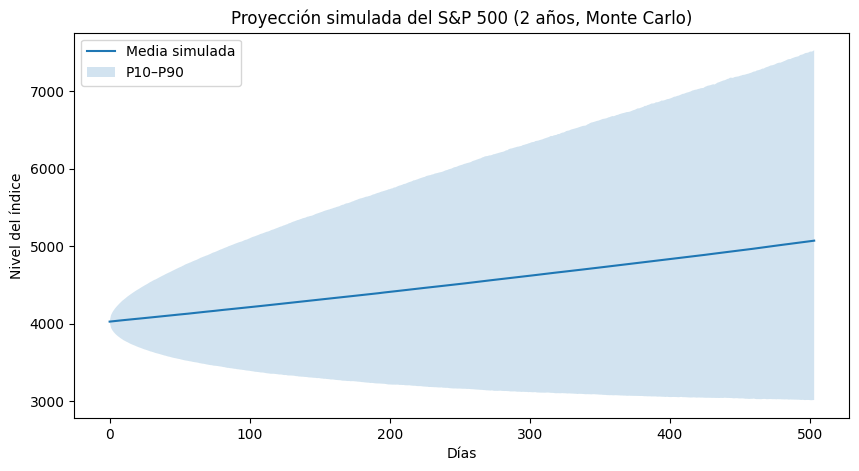

In [92]:
# BLOQUE 10 – Pregunta 12: Proyección del mercado (CAPM + Monte Carlo)

# Descargamos S&P 500 y tasa libre de riesgo (IRX) para los últimos 3 años
# ------------------------------------------------------------------
# VARIABLES CLAVE:
# - "^GSPC": índice de mercado (S&P 500).
# - "^IRX": T-Bill a 13 semanas (aprox. tasa libre de riesgo en USD).
# - start_3y: fecha inicial (últimos 3 años).
# - end_hist: fecha final (normalmente "hoy" o fecha de corte).
sp500_3y = get_adj_close("^GSPC", start_3y, end_hist)
sp500_3y = sp500_3y.sort_index()
sp500_ret_3y = sp500_3y["^GSPC"].pct_change().dropna()

irx_3y = get_adj_close("^IRX", start_3y, end_hist)
irx_3y = irx_3y.sort_index()

# Tasa libre de riesgo diaria aproximada
# ------------------------------------------------------------------
# irx_3y["^IRX"]: está en % anual aproximado.
# División entre 100 -> pasa a proporción.
# División entre 252 -> pasa de tasa anual a "tasa diaria" simple aprox.
#
# COSAS QUE PUEDES CAMBIAR:
# - Si quieres trabajar con otra convención, podrías usar 360 o 365 días.
# - Si tu fuente ya trae tasa diaria, podrías omitir el /252.
rf_daily = (irx_3y["^IRX"] / 100) / 252

# Rendimiento esperado del mercado y rf
# ------------------------------------------------------------------
# E_Rm: media histórica diaria de rendimientos del S&P 500 (últimos 3 años).
# E_rf: tasa libre de riesgo diaria promedio.
#
# Si cambias el periodo (start_3y, end_hist), cambian E_Rm y E_rf.
E_Rm = sp500_ret_3y.mean()
E_rf = rf_daily.mean()

# Prima de mercado
# ------------------------------------------------------------------
# market_premium = E[Rm] - E[rf]
# Este valor se usaría en CAPM para activos/portafolios con beta:
#   E[Ri] = E[rf] + beta_i * market_premium
market_premium = E_Rm - E_rf

print("Rendimiento esperado diario del mercado:", E_Rm)
print("Tasa libre de riesgo diaria promedio:", E_rf)
print("Prima de mercado estimada:", market_premium)

# Simulación Monte Carlo de S&P 500 para 2 años hacia adelante
# ------------------------------------------------------------------
# VARIABLES CLAVE:
# - num_days: horizonte en días.
#       252 * 2  -> 2 años de trading aprox.
#       252 * 1  -> 1 año
#       252 * 5  -> 5 años, etc.
# - num_sims: número de trayectorias simuladas.
#       10_000   -> más rápido, menos suave.
#       100_000  -> más estable, más pesado computacionalmente.
num_days = 252 * 2
num_sims = 100000

# Último nivel observado del S&P 500
# Este será el punto de partida de las simulaciones.
last_sp500 = sp500_3y["^GSPC"].iloc[-1]

# Usamos distribución normal con media E_Rm y sigma histórica
# ------------------------------------------------------------------
# sigma_mkt: volatilidad diaria histórica del mercado (últimos 3 años).
sigma_mkt = sp500_ret_3y.std()

# simulated_rets:
#   Matriz de rendimientos simulados:
#   - Filas: días en el futuro (num_days)
#   - Columnas: simulaciones (num_sims)
#
# PARÁMETROS QUE PUEDES TOCAR:
# - loc=E_Rm:
#     * media de la distribución de rendimientos.
#       Podrías cambiarla por algo tipo:
#       E_Rm_adj = E_rf + beta_mkt * market_premium  (aunque para el mercado beta=1)
# - scale=sigma_mkt:
#     * volatilidad histórica. Podrías probar escenarios con más/menos volatilidad.
simulated_rets = np.random.normal(
    loc=E_Rm,
    scale=sigma_mkt,
    size=(num_days, num_sims)
)

# Matriz de precios simulados
# ------------------------------------------------------------------
# simulated_prices tiene misma forma que simulated_rets.
# Inicializamos todo en cero y luego metemos el último precio real en t=0.
simulated_prices = np.zeros_like(simulated_rets)
simulated_prices[0, :] = last_sp500

# Dinámica del precio:
#   S_{t} = S_{t-1} * (1 + r_{t-1})
# Se aplica para cada camino (columna) en todos los días.
for t in range(1, num_days):
    simulated_prices[t, :] = simulated_prices[t-1, :] * (1 + simulated_rets[t-1, :])

# Estadísticas resumen
# ------------------------------------------------------------------
# mean_path: promedio de precios simulados en cada día (promedio sobre simulaciones).
# p10_path: percentil 10 -> escenario "pesimista".
# p90_path: percentil 90 -> escenario "optimista".
mean_path = simulated_prices.mean(axis=1)
p10_path = np.percentile(simulated_prices, 10, axis=1)
p90_path = np.percentile(simulated_prices, 90, axis=1)

# Gráfica de la proyección
# ------------------------------------------------------------------
# VARIABLES VISUALES:
# - figsize=(10, 5): tamaño de la gráfica.
# - Etiquetas y título: ajústalos si cambias horizonte o el índice.
plt.figure(figsize=(10, 5))
plt.plot(mean_path, label="Media simulada")
plt.fill_between(range(num_days), p10_path, p90_path, alpha=0.2, label="P10–P90")
plt.title("Proyección simulada del S&P 500 (2 años, Monte Carlo)")
plt.xlabel("Días")
plt.ylabel("Nivel del índice")
plt.legend()
plt.show()



# BLOQUE 11 – Pregunta 13: Rendimiento esperado del portafolio usando CAPM

**Pregunta:**  
Haciendo uso de CAPM, proyecte el rendimiento esperado de su portafolio considerando que no tiene cambios en el periodo del 28 de noviembre de 2022 al 28 de noviembre de 2024.

**Respuesta:**

Con la información histórica hasta la fecha `HOY`:

1. Se tienen las **betas individuales** de NVDA, KO y JPM respecto al S&P 500.  
2. Se calcula la **beta del portafolio**:  
   $\beta_p = \sum_i w_i \beta_i$
3. De la sección de mercado se dispone de:
   - **Rendimiento esperado diario del mercado** $E[R_m]$.  
   - **Tasa libre de riesgo diaria** $r_f$.  
   - **Prima de mercado**:  
     $\text{Prima} = E[R_m] - r_f$

4. Según CAPM, el **rendimiento esperado diario del portafolio** es:  
   $E[R_p] = r_f + \beta_p \cdot (E[R_m] - r_f)$

5. Para interpretar a un horizonte anual (aproximando 252 días de mercado por año), se puede anualizar:  
   $E[R_p]_{\text{anual}} = (1 + E[R_p])^{252} - 1$

Este valor $E[R_p]_{\text{anual}}$ es la **rentabilidad anual esperada del portafolio** según el modelo CAPM, asumiendo que los pesos se mantienen constantes y que la relación riesgo–rendimiento medida por la beta permanece estable.

In [79]:
# BLOQUE 11 – Pregunta 13: Rendimiento esperado del portafolio (CAPM)

# Reutilizamos beta_port_comb, E_rf y market_premium
# ------------------------------------------------------------------
# VARIABLES QUE VIENEN DE BLOQUES ANTERIORES:
# - beta_port_comb (o beta_port): beta del portafolio respecto al mercado.
# - E_rf: tasa libre de riesgo diaria promedio.
# - market_premium: prima de mercado diaria estimada = E_Rm - E_rf.
#
# Si cambias:
#   - el periodo para estimar E_Rm y E_rf (3 años, 5 años, etc.),
#   - el índice de mercado (S&P, Nasdaq, etc.),
#   - los activos/pesos del portafolio (que afectan beta_port),
# entonces CAMBIA el rendimiento esperado del portafolio.
beta_port = beta_port_comb

# Rendimiento esperado diario del portafolio según CAPM
# ------------------------------------------------------------------
# Fórmula CAPM:
#   E[R_p] = E[r_f] + beta_p * (E[R_m] - E[r_f])
#
# Aquí:
#   - E_rf           -> tasa libre de riesgo diaria.
#   - market_premium -> E[R_m] - E[r_f] (prima de mercado diaria).
#   - beta_port      -> beta del portafolio.
#
# COSAS QUE PUEDES TOCAR:
# - E_rf:
#     * Si usas otra proxy de tasa libre de riesgo, o la ajustas a otra base.
# - market_premium:
#     * Podrías usar una prima histórica “de libro” en lugar de la calculada.
# - beta_port:
#     * Cambiando la composición/pesos del portafolio.
E_Rp_daily = E_rf + beta_port * market_premium

# Rendimiento esperado anualizado del portafolio
# ------------------------------------------------------------------
# Conversión de rendimiento diario esperado a anual:
#   E_Rp_annual = (1 + E_Rp_daily) ** 252 - 1
#
# 252:
#   - Aproximación del número de días hábiles de trading en un año.
#
# Si quieres ser creativo:
#   - Usar 250, 360 o 365, según la convención que quieras:
#       E_Rp_annual = (1 + E_Rp_daily) ** 250 - 1
E_Rp_annual = (1 + E_Rp_daily) ** 252 - 1

print("Rendimiento esperado diario del portafolio (CAPM):", E_Rp_daily)
print("Rendimiento esperado anualizado del portafolio (CAPM):", E_Rp_annual)


Rendimiento esperado diario del portafolio (CAPM): 0.00043289483275876295
Rendimiento esperado anualizado del portafolio (CAPM): 0.11523583362816314



# BLOQUE 12 – Preguntas 14 y 15: Señales de compra/venta con medias móviles

**Pregunta 14:**  
Suponga que el día de HOY nuevamente es el 28 de noviembre de 2022.

**Pregunta 15:**  
Identifique todos los momentos donde debió de haber comprado o vendido en el periodo del 28 de noviembre de 2022 al 28 de noviembre de 2024.

**Respuesta:**

Se toma como intervalo de análisis:

- Desde: `HOY` (28 de noviembre de 2022).  
- Hasta: `HOY + 2 años` (28 de noviembre de 2024).

Para cada acción (NVDA, KO, JPM) se aplica una **estrategia técnica de medias móviles**:

1. Se calculan:
   - Una **media móvil de corto plazo** (por ejemplo, 10 días).  
   - Una **media móvil de largo plazo** (por ejemplo, 50 días).

2. Se define una señal binaria:
   - Señal = 1 cuando la media móvil corta es mayor que la larga.  
   - Señal = 0 en caso contrario.

3. Se identifican los **cruces**:
   - **Señal de compra**: cuando la señal pasa de 0 a 1  
     (la media móvil corta cruza hacia arriba a la larga).  
   - **Señal de venta**: cuando la señal pasa de 1 a 0  
     (la media móvil corta cruza hacia abajo a la larga).

4. Para cada activo se listan:
   - Todas las fechas de **compra**.  
   - Todas las fechas de **venta**.

5. Además, se pueden graficar:
   - El precio del activo en el tiempo.  
   - Las dos medias móviles.  
   - Marcadores en las fechas de compra (por ejemplo, triángulos hacia arriba).  
   - Marcadores en las fechas de venta (triángulos hacia abajo).

Esto muestra visualmente y en tabla en qué momentos, según esta regla de medias móviles, se habría recomendado comprar o vender cada una de las acciones en el periodo analizado.

[*********************100%***********************]  3 of 3 completed



ACTIVO: NVDA
Fechas de COMPRA:
DatetimeIndex(['2023-02-08', '2023-08-23', '2023-10-12', '2023-11-10',
               '2024-05-08', '2024-08-23', '2024-09-24'],
              dtype='datetime64[ns]', name='Date', freq=None)
Fechas de VENTA:
DatetimeIndex(['2023-08-18', '2023-09-19', '2023-10-20', '2024-04-24',
               '2024-07-29', '2024-09-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

ACTIVO: KO
Fechas de COMPRA:
DatetimeIndex(['2023-03-23', '2023-07-24', '2023-11-07', '2024-03-14',
               '2024-04-26'],
              dtype='datetime64[ns]', name='Date', freq=None)
Fechas de VENTA:
DatetimeIndex(['2023-05-25', '2023-08-16', '2024-03-11', '2024-04-11',
               '2024-10-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

ACTIVO: JPM
Fechas de COMPRA:
DatetimeIndex(['2023-02-08', '2023-04-20', '2023-11-15', '2024-05-01',
               '2024-10-11'],
              dtype='datetime64[ns]', name='Date', freq=None)
Fechas de VENTA:

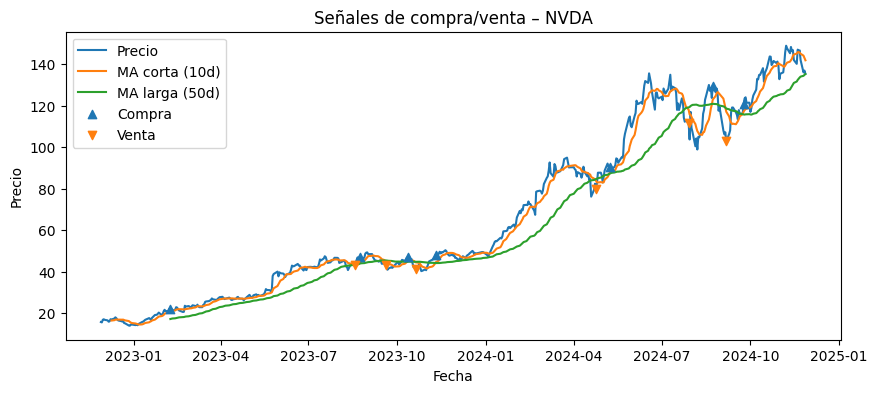

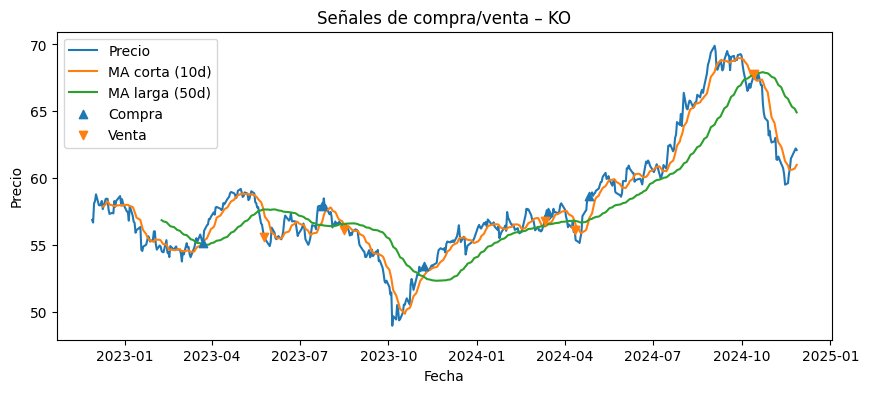

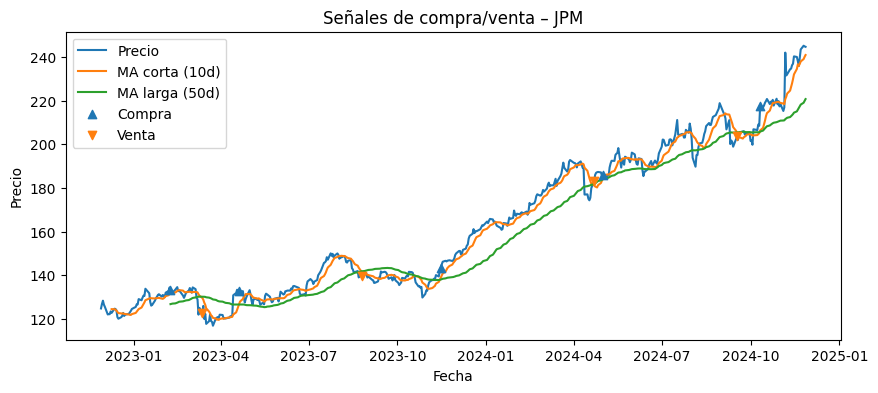

In [93]:
# BLOQUE 12 – Preguntas 14 y 15: Señales de compra/venta (medias móviles)

# Rango de fechas para generar señales
# ------------------------------------------------------------------
# VARIABLES CLAVE:
# - start_signals: fecha de inicio del periodo donde quieres generar señales.
#       Aquí está como HOY, pero podrías poner:
#           start_signals = "2020-01-01"
#           start_signals = start_2y
# - end_signals: fecha final del periodo.
#       end_2y_forward sugiere "2 años hacia adelante" desde hoy
#       (o desde alguna fecha de referencia).
# Si cambias estas dos, cambias el tramo de precios sobre el que se calculan
# las medias móviles y, por tanto, las señales.
start_signals = HOY
end_signals = end_2y_forward

# Descarga de precios para el rango elegido
prices_signals = get_adj_close(tickers, start_signals, end_signals)
prices_signals = prices_signals.sort_index()

def moving_average_signals(price_series, short_window=10, long_window=50):
    """
    Genera señales de compra/venta usando el cruce de dos medias móviles.

    PARÁMETROS CLAVE:
    - price_series: serie de precios de un activo.
    - short_window: ventana (en días) de la media móvil corta.
          * Ejemplos:
              10 -> muy sensible, más "ruido"
              20 -> más suave
    - long_window: ventana (en días) de la media móvil larga.
          * Ejemplos:
              50, 100, 200 -> típicas en análisis técnico.
          * Regla básica: long_window > short_window.
    """

    # Medias móviles
    short_ma = price_series.rolling(window=short_window).mean()
    long_ma = price_series.rolling(window=long_window).mean()

    # Señal:
    #   signal = 1 cuando MA corta > MA larga (tendencia alcista)
    #   signal = 0 en caso contrario (no largos, o fuera del activo).
    signal = (short_ma > long_ma).astype(int)

    # Desfasamos la señal un día para detectar los cambios (los cruces)
    signal_shift = signal.shift(1)

    # buy_signals: pasa de 0 -> 1 (cruce alcista)
    buy_signals = (signal == 1) & (signal_shift == 0)

    # sell_signals: pasa de 1 -> 0 (cruce bajista)
    sell_signals = (signal == 0) & (signal_shift == 1)

    return {
        "short_ma": short_ma,
        "long_ma": long_ma,
        "buy": buy_signals,
        "sell": sell_signals
    }

# Calculamos señales para cada ticker
# ------------------------------------------------------------------
# VARIABLES IMPLÍCITAS:
# - tickers: lista de activos.
# - short_window y long_window: si quieres cambiar la estrategia,
#   modifica los parámetros al llamar moving_average_signals:
#       moving_average_signals(prices_signals[ticker], short_window=20, long_window=100)
signals = {}
for ticker in tickers:
    signals[ticker] = moving_average_signals(prices_signals[ticker])

# Mostrar fechas de compra/venta
# ------------------------------------------------------------------
# Aquí solamente imprimimos las fechas en las que se activaron las señales.
for ticker in tickers:
    buys = prices_signals.index[signals[ticker]["buy"]]
    sells = prices_signals.index[signals[ticker]["sell"]]
    print(f"\nACTIVO: {ticker}")
    print("Fechas de COMPRA:")
    print(buys)
    print("Fechas de VENTA:")
    print(sells)

# Graficar precios con señales
# ------------------------------------------------------------------
# VARIABLES VISUALES QUE PUEDES CAMBIAR:
# - figsize=(10, 4): tamaño de la gráfica.
# - etiquetas de las curvas y título.
for ticker in tickers:
    plt.figure(figsize=(10, 4))

    # Precio del activo
    plt.plot(prices_signals.index, prices_signals[ticker], label="Precio")

    # Medias móviles (usa los mismos short_window y long_window que en la función)
    plt.plot(signals[ticker]["short_ma"].index,
             signals[ticker]["short_ma"],
             label="MA corta (10d)")
    plt.plot(signals[ticker]["long_ma"].index,
             signals[ticker]["long_ma"],
             label="MA larga (50d)")

    # Puntos de compra y venta
    buy_dates = prices_signals.index[signals[ticker]["buy"]]
    sell_dates = prices_signals.index[signals[ticker]["sell"]]

    plt.scatter(buy_dates,
                prices_signals.loc[buy_dates, ticker],
                marker="^", label="Compra", zorder=5)
    plt.scatter(sell_dates,
                prices_signals.loc[sell_dates, ticker],
                marker="v", label="Venta", zorder=5)

    plt.title(f"Señales de compra/venta – {ticker}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.show()



# BLOQUE 13 – Pregunta 16: Comparación del rendimiento esperado (CAPM) vs rendimiento real del portafolio

**Pregunta:**  
Realice la comparación del rendimiento esperado calculado con CAPM y el rendimiento real que tuvo su portafolio de acuerdo al inciso 15.

**Respuesta:**

1. **Rendimiento esperado (CAPM)**  
   - A partir de la beta del portafolio $\beta_p$, la tasa libre de riesgo $r_f$ y la prima de mercado, se obtuvo el **rendimiento esperado diario del portafolio** según CAPM, y su versión anualizada $E[R_p]_{\text{anual}}$.

2. **Rendimiento real del portafolio con la estrategia de trading**  
   - Para cada activo (NVDA, KO, JPM), se simula el resultado de aplicar la estrategia de medias móviles:
     - Se parte de un valor inicial (por ejemplo 100).  
     - Cada vez que se genera una señal de compra, se entra al activo.  
     - Se sale cuando aparece la siguiente señal de venta.  
     - El capital se multiplica por el factor:  
       $\dfrac{\text{precio de venta}}{\text{precio de compra}}$  
       en cada operación.  
     - Al final del periodo, se obtiene un **rendimiento total real** para cada activo.

   - Luego, se combinan estos rendimientos de los activos según los mismos pesos del portafolio:  
     $R_{\text{real, port}} = w_{\text{NVDA}} R_{\text{real, NVDA}} + w_{\text{KO}} R_{\text{real, KO}} + w_{\text{JPM}} R_{\text{real, JPM}}$

3. **Comparación**  
   - Se confrontan:
     - El **rendimiento esperado del portafolio según CAPM** (teórico, promedio esperado).  
     - El **rendimiento real del portafolio** resultante de la estrategia de compra/venta.  
   - Se presenta una tabla con ambos valores y, opcionalmente, una gráfica de barras para visualizar cuál es mayor y la diferencia entre ellos.

Esta comparación permite evaluar si, en el periodo y con la estrategia escogida, el comportamiento real del portafolio fue mejor o peor que lo que pronosticaba el modelo CAPM.
```0

Rendimientos reales por activo (estrategia MA):
NVDA    1.569375
KO      0.169651
JPM     0.358325
dtype: float64

Rendimiento real del portafolio (estrategia MA): 0.5061979856010931

Comparación de rendimientos:
                 Método  Rendimiento
0       CAPM (esperado)     0.115236
1  Estrategia MA (real)     0.506198


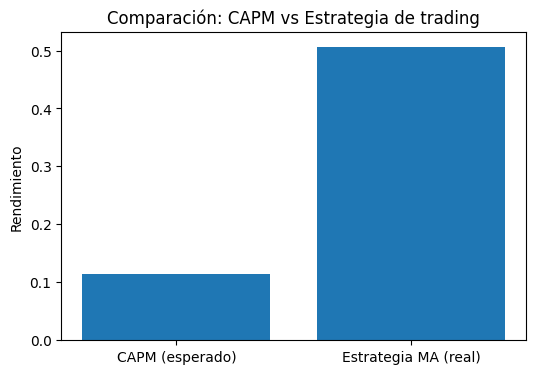

In [81]:
# BLOQUE 13 – Pregunta 16: Comparación CAPM vs rendimiento real del portafolio

def compute_trade_return(price_series, signal_dict, initial_value=100):
    """
    Simula comprar en cada señal de compra y vender
    en la señal de venta correspondiente. Multiplica
    el capital por (P_venta / P_compra) en cada trade.

    PARÁMETROS CLAVE:
    - price_series: serie de precios del activo (alineada con las señales).
    - signal_dict: diccionario con:
        * "buy": serie booleana (True en fechas de compra)
        * "sell": serie booleana (True en fechas de venta)
      Generado antes con moving_average_signals.
    - initial_value: capital inicial (valor base de la simulación).
        * Ejemplos:
            100   -> capital base normalizado (tipo índice)
            1_000 -> montos en “pesos”
            10_000, etc.
    """

    # Índices (posiciones) donde hay señal de compra/venta
    buys_idx = np.where(signal_dict["buy"])[0]
    sells_idx = np.where(signal_dict["sell"])[0]

    value = initial_value

    # j recorre las ventas, i recorre las compras
    j = 0
    for i in range(len(buys_idx)):
        buy_i = buys_idx[i]

        # Buscar la primera venta después de la compra
        while j < len(sells_idx) and sells_idx[j] <= buy_i:
            j += 1
        if j >= len(sells_idx):
            break
        sell_i = sells_idx[j]

        price_buy = price_series.iloc[buy_i]
        price_sell = price_series.iloc[sell_i]

        # Actualizar valor del capital:
        #   value *= (precio_venta / precio_compra)
        value *= (price_sell / price_buy)
        j += 1

    # Rendimiento total:
    #   (valor_final / valor_inicial) - 1
    total_return = value / initial_value - 1
    return total_return

# Rendimientos reales por activo usando la estrategia
# ------------------------------------------------------------------
# VARIABLES CLAVE:
# - prices_signals: precios del periodo en el que definiste las señales (BLOQUE 12).
# - signals: diccionario con señales de compra/venta por ticker.
# - initial_value=100: capital inicial por activo para comparar de forma homogénea.
real_returns_assets = {}
for ticker in tickers:
    real_returns_assets[ticker] = compute_trade_return(
        prices_signals[ticker],
        signals[ticker],
        initial_value=100
    )

# Convertimos el diccionario a Serie para manejarlo más cómodo
real_returns_assets = pd.Series(real_returns_assets)

# Rendimiento real del portafolio con los mismos pesos
# ------------------------------------------------------------------
# Aquí combinas los rendimientos por activo con los pesos del portafolio:
#   real_portfolio_return = sum_i ( w_i * R_i_real )
#
# VARIABLES:
# - weights: mismos pesos del portafolio que usaste en bloques anteriores.
# - real_returns_assets: rendimientos totales (no diarios, sino del periodo) por activo.
real_portfolio_return = np.dot(weights, real_returns_assets.values)

print("Rendimientos reales por activo (estrategia MA):")
print(real_returns_assets)

print("\nRendimiento real del portafolio (estrategia MA):", real_portfolio_return)

# Comparación con el rendimiento esperado anualizado CAPM
# ------------------------------------------------------------------
# E_Rp_annual:
#   rendimiento esperado anualizado del portafolio por CAPM (del BLOQUE 11).
#
# OJO:
# - E_Rp_annual está en base anual.
# - real_portfolio_return es el rendimiento total del período de la estrategia.
#   Idealmente deberías asegurarte de que el periodo de la estrategia
#   sea de ~1 año si quieres comparar “anual vs anual” directamente,
#   o anualizar real_portfolio_return si cubre un periodo distinto.
comparison = pd.DataFrame({
    "Método": ["CAPM (esperado)", "Estrategia MA (real)"],
    "Rendimiento": [E_Rp_annual, real_portfolio_return]
})

print("\nComparación de rendimientos:")
print(comparison)

# Gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(comparison["Método"], comparison["Rendimiento"])
plt.title("Comparación: CAPM vs Estrategia de trading")
plt.ylabel("Rendimiento")
plt.show()
